# Thông tin
1. **Họ Tên:** Huỳnh Trung Nghĩa    **MSSV:** 22520945
2. **Họ Tên:** Nguyễn Hùng Phát     **MSSV:** 22521074
3. **Đồ án:** Phát hiện việc đeo khẩu trang
4. **Ngày báo cáo:** 30/5/2024

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import library

In [2]:
import os
import cv2
import numpy as np
import pandas as pd

from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Preprocessing (tiền xử lí)

### Trích xuất đặc trưng HOG

In [3]:

def extract_hog_features(image):
    image = cv2.resize(image, (128, 128))
    hog_features = []
    for channel in cv2.split(image):
        fd, hog_image = hog(channel, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(4,4),
                            visualize=True, transform_sqrt=True, block_norm="L2")
        hog_features.append(fd)
    combined_hog_features = np.hstack(hog_features)
    return combined_hog_features



### Gán nhãn dữ liệu

In [4]:
def load_data_from_folder(folder,lable):
    images = []
    labels = []
    filenames = os.listdir(folder)

    for filename in filenames:
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)

        hog_features = extract_hog_features(img)

        images.append(hog_features)
        labels.append(lable)

    return np.array(images), np.array(labels), filenames


### Tải dữ liệu (Img)

In [5]:
mask_images_folder = '/content/drive/MyDrive/CS231_CV/TGMT/dataset/mask/mask'
no_mask_images_folder = '/content/drive/MyDrive/CS231_CV/TGMT/dataset/no_mask/no_mask'
mask_images, mask_labels, mask_filenames = load_data_from_folder(mask_images_folder, 1)
no_mask_images, no_mask_labels, no_mask_filenames = load_data_from_folder(no_mask_images_folder, 0)

In [6]:
no_mask_labels

array([0, 0, 0, ..., 0, 0, 0])

In [7]:
mask_labels

array([1, 1, 1, ..., 1, 1, 1])

### Show images

In [ ]:
mask_img = os.listdir(mask_images_folder)
no_mask_img = os.listdir(no_mask_images_folder)

Images Masks:


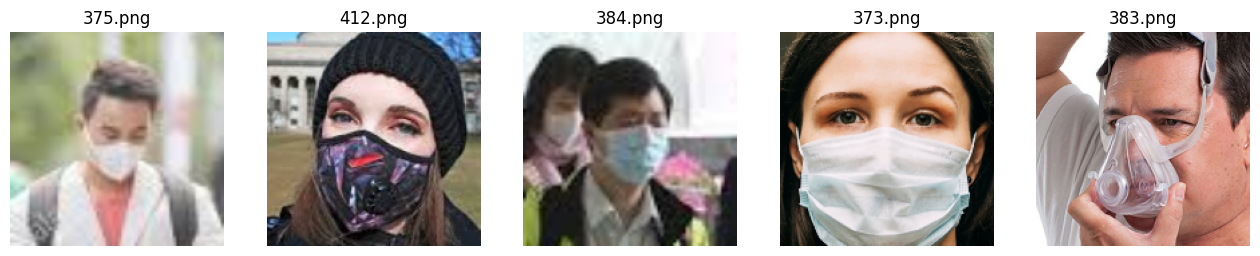

Images No Masks:


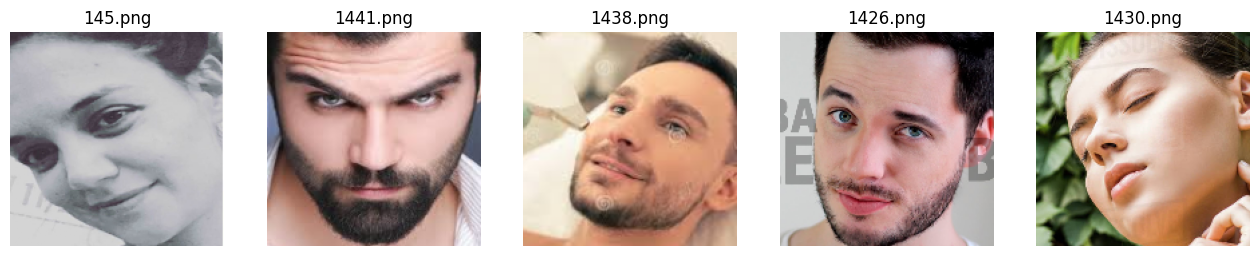

In [ ]:
def show_images(image_dir, image_files, num_images=5):
    plt.figure(figsize=(16, 8))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        img_path = os.path.join(image_dir, image_files[i])
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.title(image_files[i])
        plt.axis('off')
    plt.show()

# Display some images with masks
print("Images Masks:")
show_images(mask_images_folder, mask_img)

print("Images No Masks:")
show_images(no_mask_images_folder, no_mask_img)

### Kiểm tra mẫu mỗi lớp

Class No Mask: 1484 samples
Class Mask: 1266 samples


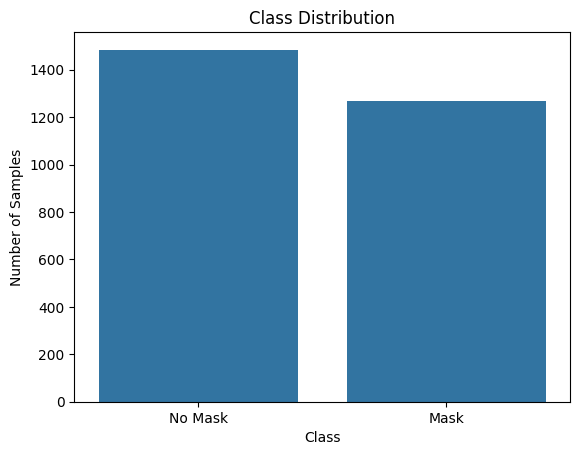

In [ ]:
# Tạo một DataFrame với các nhãn
labels = np.concatenate([mask_labels, no_mask_labels])
df = pd.DataFrame({'label': labels})

# Đếm số lượng mẫu của từng lớp
class_distribution = df['label'].value_counts()

# In ra số lượng mẫu của từng lớp
for label, count in class_distribution.items():
    class_name = 'Mask' if label == 1.0 else 'No Mask'
    print(f'Class {class_name}: {count} samples')

# Hiển thị phân phối lớp bằng biểu đồ cột
sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.xticks([0, 1], ['No Mask', 'Mask'])
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.show()


### Chia dataset

In [8]:
# Concatenate the data and labels
X = np.concatenate((mask_images, no_mask_images), axis=0)
y = np.concatenate((mask_labels, no_mask_labels), axis=0)
filenames = mask_filenames + no_mask_filenames

# Split the data into training and testing sets
X_train, X_test, y_train, y_test, filenames_train, filenames_test = train_test_split(X, y, filenames, test_size=0.2, random_state=42)



# Training Model

### SVM_model

In [9]:
svm_model = SVC(C = 0.001, gamma = 1, kernel = 'poly')
svm_model.fit(X_train, y_train)
svm_predictions = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print(f'SVM Accuracy: {svm_accuracy}')

SVM Accuracy: 0.9654545454545455


In [ ]:
y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       285
           1       0.96      0.97      0.96       265

    accuracy                           0.97       550
   macro avg       0.97      0.97      0.97       550
weighted avg       0.97      0.97      0.97       550



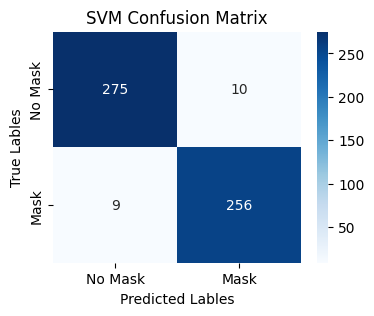

In [ ]:
svm_cm = confusion_matrix(y_test, svm_predictions)
plt.figure(figsize=(4, 3))
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Mask', 'Mask'], yticklabels=['No Mask', 'Mask'])
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted Lables')
plt.ylabel('True Lables')
plt.show()

### KNN_model

In [10]:
# Huấn luyện mô hình KNN
knn_model = KNeighborsClassifier(n_neighbors = 3, weights = 'distance', metric = 'manhattan')
knn_model.fit(X_train, y_train)
knn_predictions = knn_model.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_predictions)
print(f'KNN Accuracy: {knn_accuracy}')

KNN Accuracy: 0.9581818181818181


In [ ]:
y_pred = knn_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       285
           1       0.95      0.96      0.96       265

    accuracy                           0.96       550
   macro avg       0.96      0.96      0.96       550
weighted avg       0.96      0.96      0.96       550



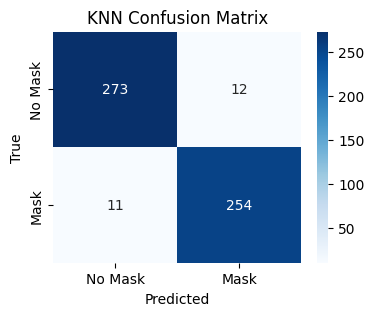

In [ ]:
knn_cm = confusion_matrix(y_test, knn_predictions)
plt.figure(figsize=(4, 3))
sns.heatmap(knn_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Mask', 'Mask'], yticklabels=['No Mask', 'Mask'])
plt.title('KNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Evaluate

### Chuyển img -> img_hog

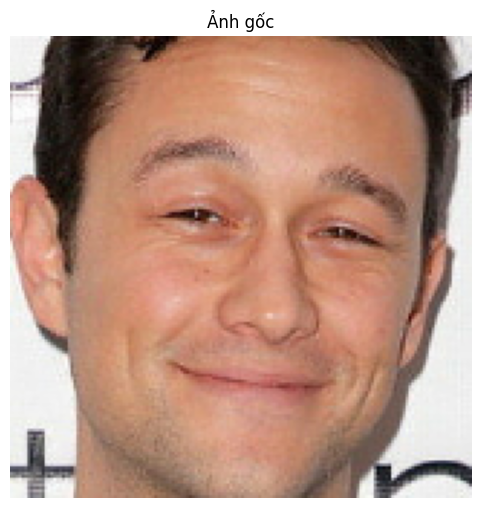

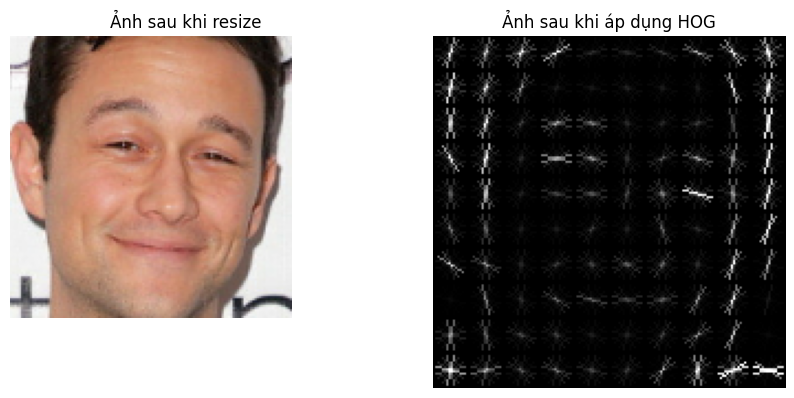

In [ ]:
from skimage import exposure

image_path = '/content/drive/MyDrive/CS231_CV/TGMT/dataset/no_mask/no_mask/101.png'

image = cv2.imread(image_path)
image_resize = cv2.resize(image, (128,128))

hog_features = []
for channel in cv2.split(image):                  # Tách ảnh thành các kênh màu riêng biệt
    fd, hog_image = hog(channel, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(4,4),
                            visualize=True, transform_sqrt=True, block_norm="L2")
    hog_features.append(fd)
combined_hog_features = np.hstack(hog_features)   # Kết hợp các đặc trưng HOG từ các kênh màu


# Tăng cường độ sáng của ảnh HOG cho dễ nhìn
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0,1))

fig, (ax1) = plt.subplots(1, 1, figsize=(10, 6), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax1.set_title('Ảnh gốc')


fig, ( ax2, ax3) = plt.subplots(1, 2, figsize=(10, 6), sharex=True, sharey=True)

ax2.axis('off')
ax2.imshow(cv2.cvtColor(image_resize, cv2.COLOR_BGR2RGB))
ax2.set_title('Ảnh sau khi resize')

ax3.axis('off')
ax3.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax3.set_title('Ảnh sau khi áp dụng HOG')

plt.show()

### Xuất ảnh (Img)

In [ ]:


def display_images(indices, case_name, y_predictions):
    max_images = 5  # Maximum number of images to display
    max_images_per_row = 5
    image_size = (128, 128)
    num_images = min(len(indices), max_images)
    num_rows = (num_images // max_images_per_row) + int(num_images % max_images_per_row != 0)

    fig = plt.figure(figsize=(8,6))
    fig.suptitle(case_name, fontsize=10)

    for i, idx in enumerate(indices[:max_images]):  # Limit to the first max_images
        img_path = os.path.join(mask_images_folder if y_test[idx] == 1 else no_mask_images_folder, filenames_test[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # img = cv2.resize(img, image_size)

        # Convert y_test and y_predictions to 'mask' or 'no_mask'
        true_label = 'mask' if y_test[idx] == 1 else 'no_mask'
        predicted_label = 'mask' if y_predictions[idx] == 1 else 'no_mask'

        ax = fig.add_subplot(num_rows, max_images_per_row, i + 1)
        ax.imshow(img)
        ax.set_title(f'True: {true_label}\n Pred: {predicted_label}', fontsize=10)
        ax.axis('off')

    plt.subplots_adjust()
    plt.tight_layout()
    plt.show()


In [ ]:
def four_cases(y_predictions):
    # Identify the indices of the four cases
    case_indices = { "mask_correct": [], "mask_incorrect": [], "no_mask_incorrect": [], "no_mask_correct": []}

    for i, (true_label, pred_label) in enumerate(zip(y_test, y_predictions)):
        if true_label == 1 and pred_label == 1:
            case_indices["mask_correct"].append(i)
        elif true_label == 1 and pred_label == 0:
            case_indices["mask_incorrect"].append(i)
        elif true_label == 0 and pred_label == 0:
            case_indices["no_mask_incorrect"].append(i)
        elif true_label == 0 and pred_label == 1:
            case_indices["no_mask_correct"].append(i)

    # Display incorrectly predicted images
    display_images(case_indices["mask_correct"], "Mask Correct", y_predictions)
    display_images(case_indices["mask_incorrect"], "Mask Incorrect", y_predictions)
    display_images(case_indices["no_mask_incorrect"], "No Mask Correct", y_predictions)
    display_images(case_indices["no_mask_correct"], "No Mask Incorrect", y_predictions)

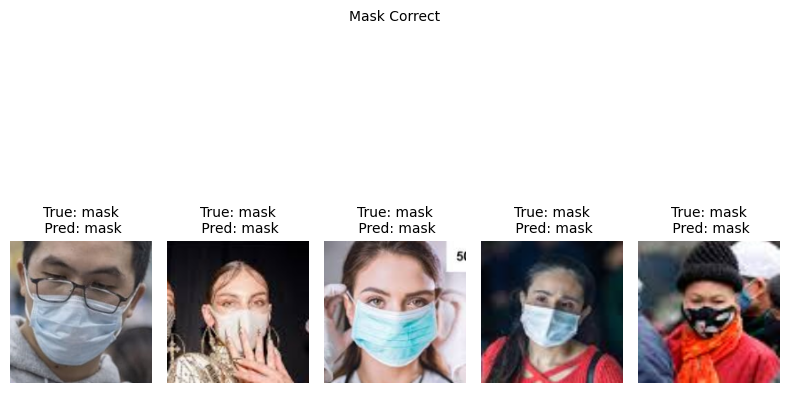

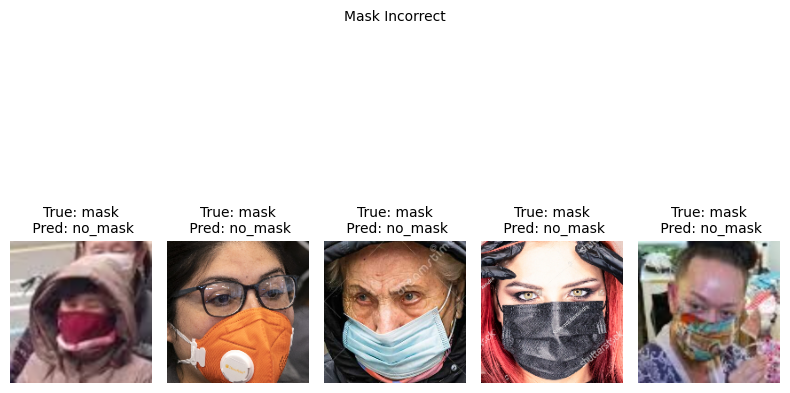

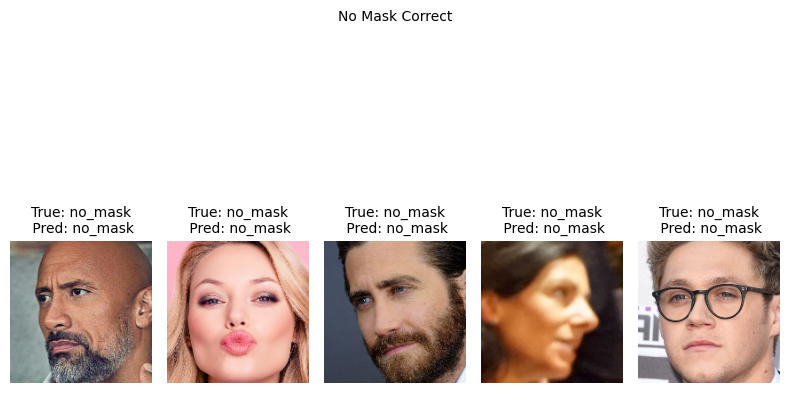

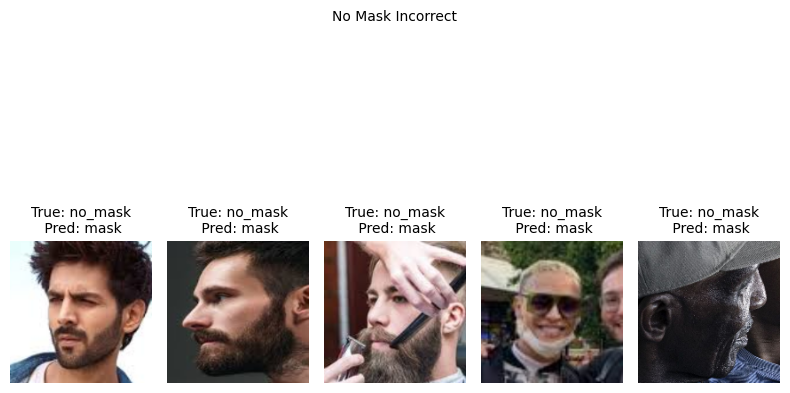

In [ ]:
four_cases(svm_predictions)

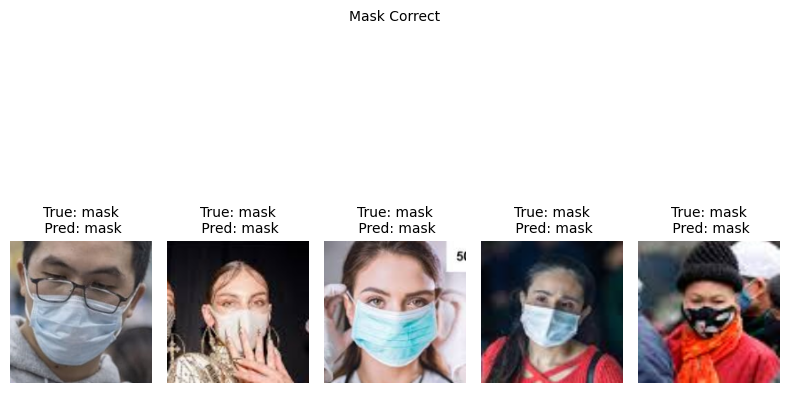

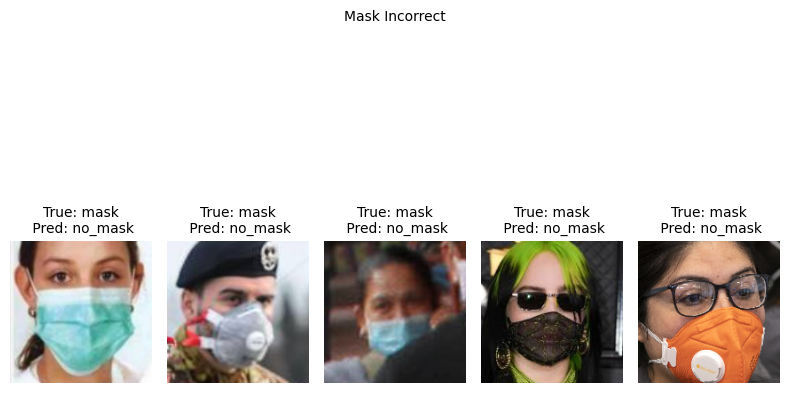

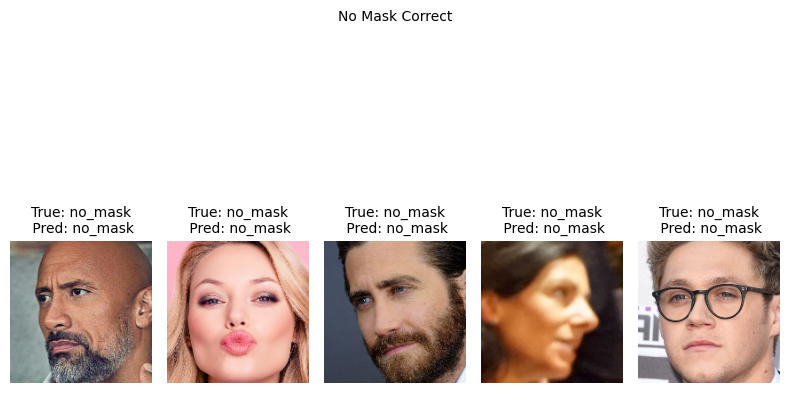

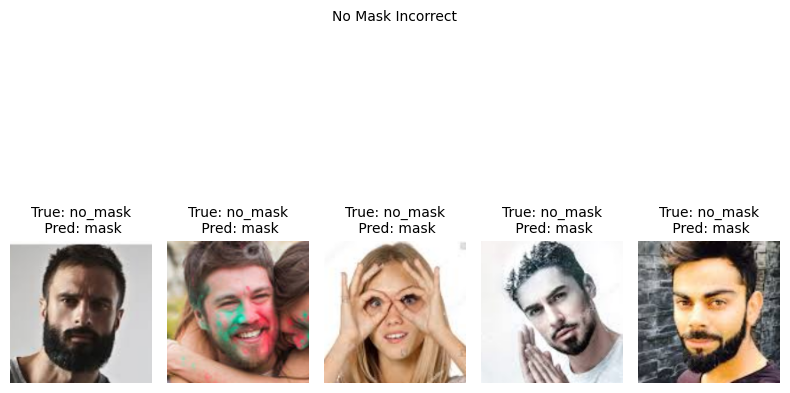

In [ ]:
four_cases(knn_predictions)

### Test 1 tập ảnh

In [23]:
def preprocess_image(image_path, target_size):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image not found or unable to load: {image_path}")
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    hog_features = extract_hog_features(image)

    return hog_features


folder = '/content/drive/MyDrive/CS231_CV/TGMT/dataset_demo/test'
filenames = os.listdir(folder)

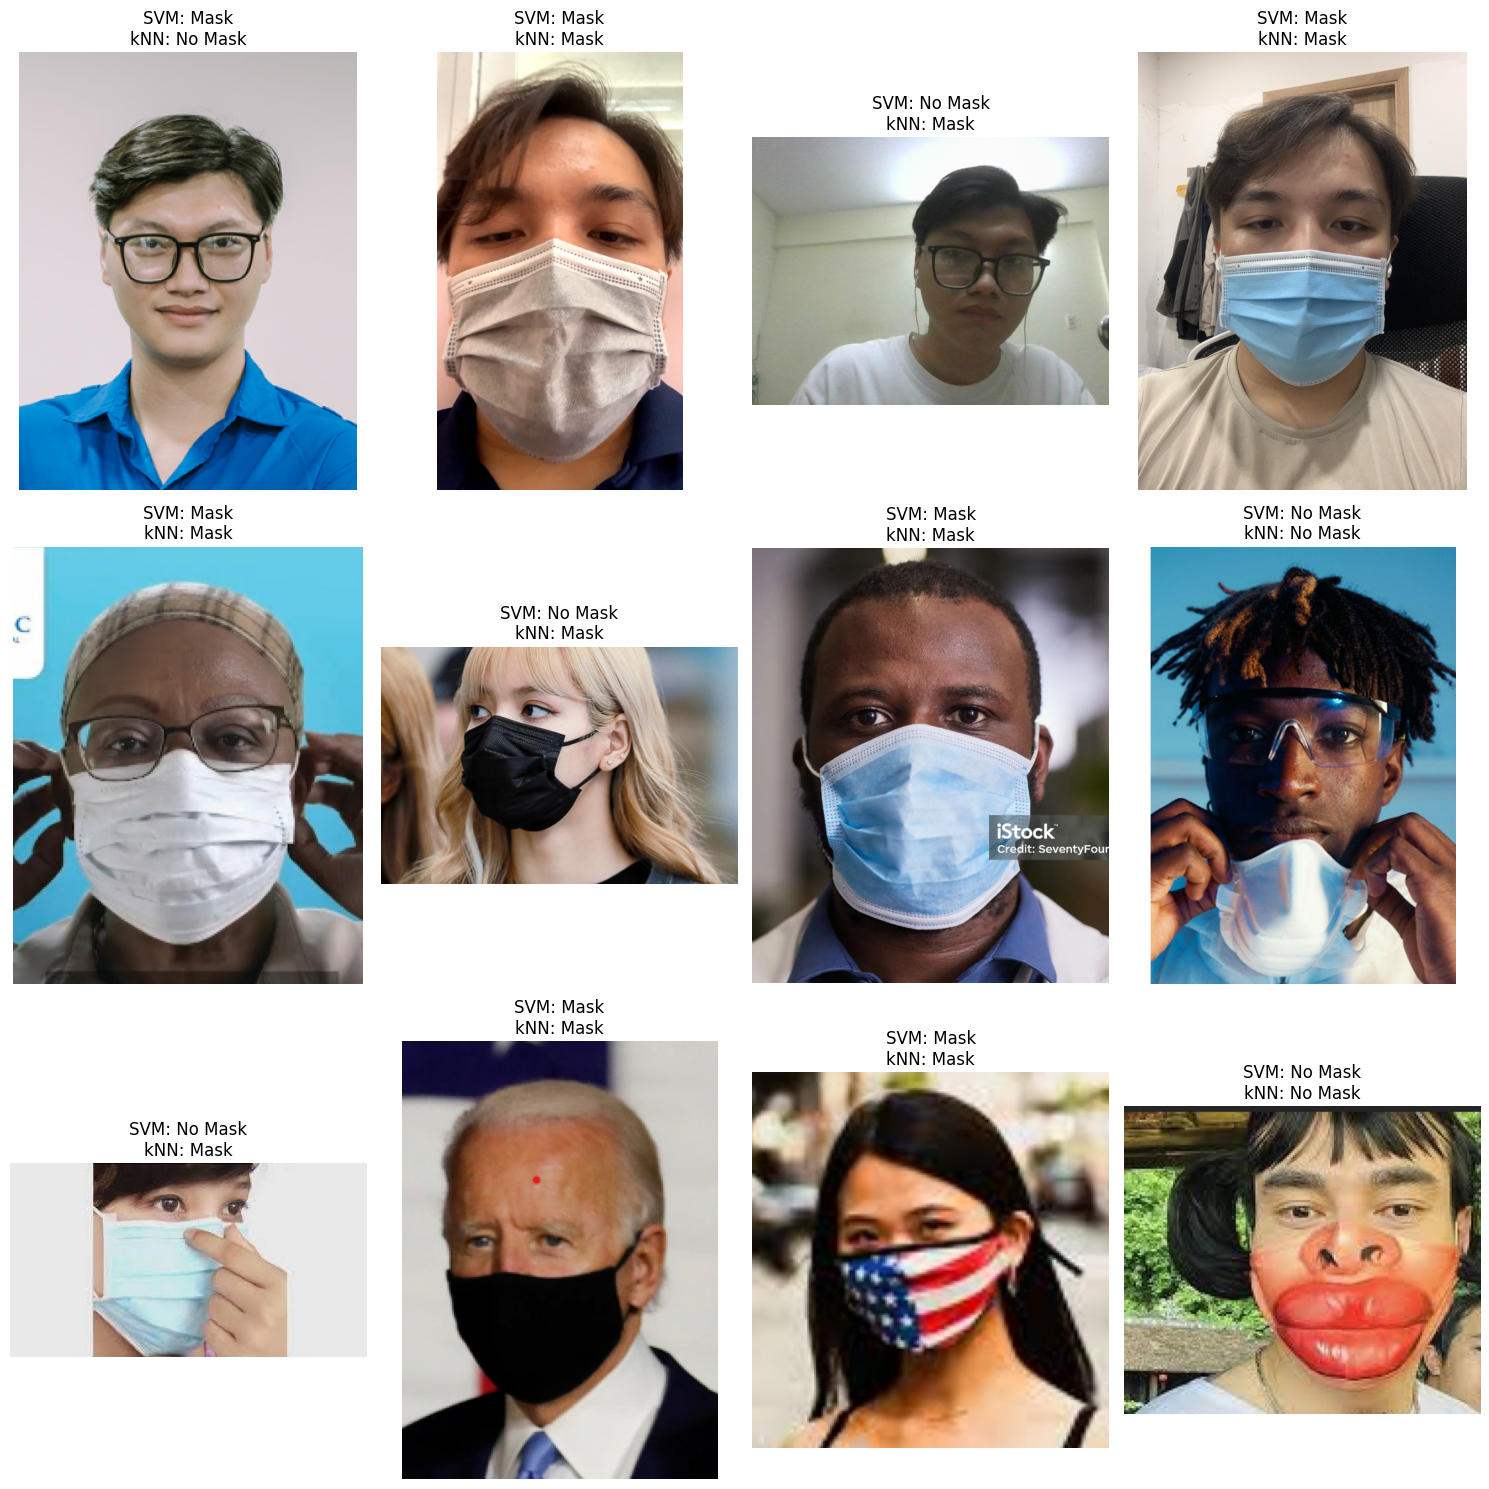

In [24]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Đoạn code để hiển thị ảnh theo từng hàng, mỗi hàng 4 ảnh
images_per_row = 4
num_images = len(filenames)
num_rows = (num_images - 1) // images_per_row + 1

fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 15))

for i, filename in enumerate(filenames):
    row = i // images_per_row
    col = i % images_per_row

    image_path = os.path.join(folder, filename)

    # Tiền xử lý ảnh
    input_image = preprocess_image(image_path, (128, 128))

    # Thêm một chiều để phù hợp với định dạng đầu vào của mô hình (1, height, width, channels)
    input_image = np.expand_dims(input_image, axis=0)

    # Dự đoán nhãn cho ảnh đầu vào bằng SVM
    prediction_svm = svm_model.predict(input_image)
    predicted_label_svm = prediction_svm[0]

    # Dự đoán nhãn cho ảnh đầu vào bằng kNN
    prediction_knn = knn_model.predict(input_image)
    predicted_label_knn = prediction_knn[0]

    # Hiển thị ảnh và kết quả dự đoán từng mô hình trên từng ô của grid subplot
    ax = axes[row, col]
    ax.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    ax.set_title(f'SVM: {"Mask" if predicted_label_svm == 1 else "No Mask"}\n'
                 f'kNN: {"Mask" if predicted_label_knn == 1 else "No Mask"}')
    ax.axis('off')

# Xóa các ô trống nếu số lượng ảnh không đủ để điền đầy grid subplot
for i in range(num_images, num_rows * images_per_row):
    row = i // images_per_row
    col = i % images_per_row
    fig.delaxes(axes[row, col])

# Hiển thị grid subplot
plt.tight_layout()
plt.show()


### Test 1 ảnh bất kì

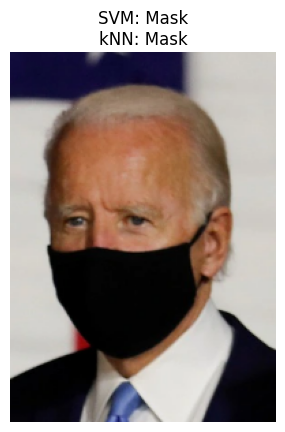

In [22]:
def preprocess_image(image_path, target_size):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image not found or unable to load: {image_path}")
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    hog_features = extract_hog_features(image)

    return hog_features

# Đường dẫn đến ảnh cần dự đoán

image_path = '/content/Screenshot 2024-06-06 084249.png'


# Tiền xử lý ảnh
input_image = preprocess_image(image_path, (128, 256))

# Thêm một chiều để phù hợp với định dạng đầu vào của mô hình (1, height, width, channels)
input_image = np.expand_dims(input_image, axis=0)

# Dự đoán nhãn cho ảnh đầu vào bằng SVM
prediction_svm = svm_model.predict(input_image)
predicted_label_svm = prediction_svm[0]

# Dự đoán nhãn cho ảnh đầu vào bằng kNN
prediction_knn = knn_model.predict(input_image)
predicted_label_knn = prediction_knn[0]



# Hiển thị ảnh và kết quả dự đoán
plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
plt.title(f'SVM: {"Mask" if predicted_label_svm == 1 else "No Mask"}\n'
                 f'kNN: {"Mask" if predicted_label_knn == 1 else "No Mask"}')
plt.axis('off')
plt.show()


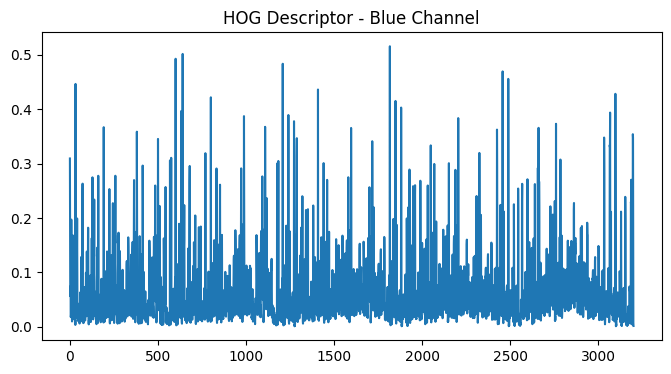

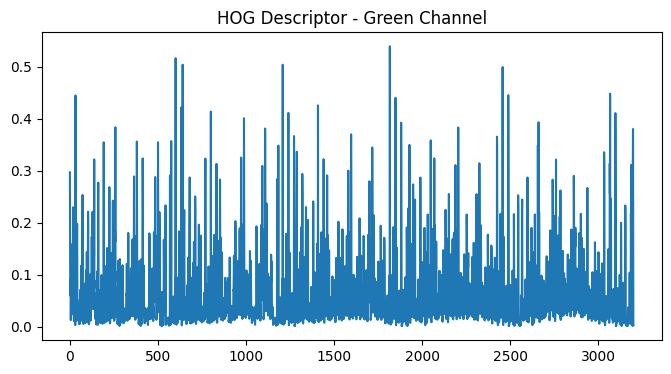

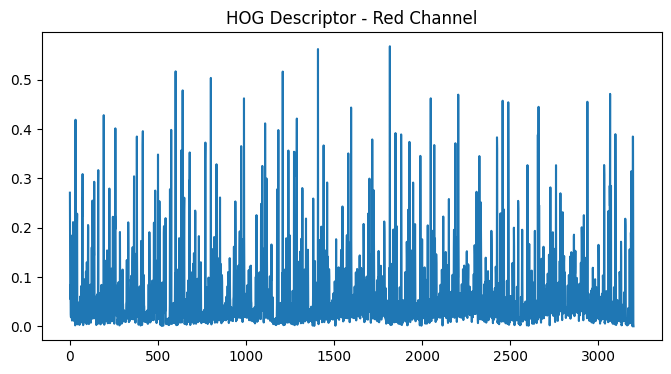

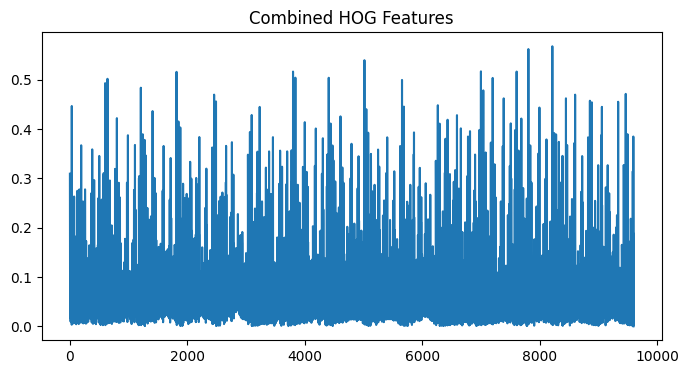

In [ ]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog

def extract_hog_features(image):
    image = cv2.resize(image, (128, 128))

    hog_features = []
    hog_images = []

    for channel in cv2.split(image):                # Tách ảnh thành các kênh màu riêng biệt
        fd, hog_image = hog(channel, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(4, 4),
                            visualize=True, transform_sqrt=True, block_norm="L2")
        hog_features.append(fd)
        hog_images.append(hog_image)

    combined_hog_features = np.hstack(hog_features)  # Kết hợp các đặc trưng HOG từ các kênh màu

    return hog_features, combined_hog_features, hog_images

# Đọc hình ảnh
image = cv2.imread('/content/drive/MyDrive/CS231_CV/TGMT/dataset/no_mask/no_mask/101.png')

# Trích xuất các đặc trưng HOG
hog_features, combined_hog_features, hog_images = extract_hog_features(image)

# Vẽ biểu đồ HOG cho từng kênh màu
color_channels = ['Blue', 'Green', 'Red']
for i in range(3):

    plt.figure(figsize=(8, 4))
    plt.title(f'HOG Descriptor - {color_channels[i]} Channel')
    plt.plot(hog_features[i])
    plt.show()

# Vẽ biểu đồ HOG tổng hợp từ cả ba kênh màu
plt.figure(figsize=(8, 4))
plt.title('Combined HOG Features')
plt.plot(combined_hog_features)
plt.show()